<a href="https://colab.research.google.com/github/Koks-creator/OcrModelAppAndStuff/blob/main/IAM_OCR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip

!mkdir data
!mkdir data/words

!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
!pip freeze | grep tensorflow

tensorflow==2.18.0
tensorflow-datasets==4.9.7
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.37.1
tensorflow-metadata==1.16.1
tensorflow-probability==0.25.0
tensorflow-text==2.18.1


In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [ ]:
import os
import csv
from google.colab import drive
from typing import Tuple, List
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from tensorflow.types.experimental import TensorLike
import cv2
from google.colab.patches import cv2_imshow
from keras.saving import register_keras_serializable
import pickle
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
BASE_PATH = "data"
BASE_IMAGES_PATH = f"{BASE_PATH}/words"
TRAIN_SIZE = .8
VAL_SIZE = .15
TEST_SIZE = .05
AUTOTUNE = tf.data.AUTOTUNE
CHECKPOINT_PATH = "/content/drive/MyDrive/ocr_checkpoints/checkpoint_{epoch:02d}"
LOAD_CHECKPOINT = True
MODEL_PATH = "ocr_model.h5"
NUM2CHAR_PATH = "num_to_char.pkl"

# HYPER PARAMS
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
PADDING_TOKEN = 99
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 32
RNN_LAYERS = 3
RNN_UNITS = 512
OOV_TOKEN = "[UNK]"
EPOCHS = 65

In [ ]:
drive.mount('/content/drive')
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)

Mounted at /content/drive


In [ ]:
CHECKPOINT_DIR

'/content/drive/MyDrive/ocr_checkpoints'

In [ ]:
!ls $CHECKPOINT_DIR

checkpoint_45.keras  checkpoint_48.keras  training_log.csv


In [ ]:
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# **Prepare data**

*   Get words list
*   Split data
*   Get image paths and labels
*   Create vocabulary
*   Create char to id mapping
*   Resize images
*   Create final datasets



Words list

In [ ]:
words_list = []

with open(f"{BASE_PATH}/words.txt") as w_f:
    words = w_f.readlines()
    for line in words:
        if line[0] == "#":
            continue
        if line.split(" ")[1] != "err":
            words_list.append(line)

print(f"{len(words_list)=}")
np.random.shuffle(words_list)

len(words_list)=96456


In [ ]:
words_list[:10] #96456

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n']

Slice dataset into train, val, test datasets

In [ ]:
num_samples = len(words_list)
train_range = slice(0, int(TRAIN_SIZE * num_samples))
val_range = slice(int(train_range.stop), int(train_range.stop + (VAL_SIZE * num_samples)))
test_range = slice(val_range.stop,  int(val_range.stop + (TEST_SIZE * num_samples)))

print(f"{train_range=}, {val_range=}, {test_range=}")

train_samples = words_list[train_range]
val_samples = words_list[val_range]
test_samples = words_list[test_range]

print(f"{len(train_samples)=}")
print(f"{len(val_samples)=}")
print(f"{len(test_samples)=}")

train_range=slice(0, 77164, None), val_range=slice(77164, 91632, None), test_range=slice(91632, 96454, None)
len(train_samples)=77164
len(val_samples)=14468
len(test_samples)=4822


Get image path and clean labels

In [ ]:
def get_image_paths_and_labels(samples: list) -> Tuple[list, list]:
    paths = []
    corrected_samples = []

    for (ind, file_line) in enumerate(samples):
        file_line = file_line.replace("\n", "")
        line_split = file_line.split()

        image_name = line_split[0]
        part_1, part_2 = image_name.split("-")[:2]
        img_path = os.path.join(BASE_IMAGES_PATH, part_1, f"{part_1}-{part_2}", f"{image_name}.png")

        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line)
    return paths, corrected_samples


def clean_labels(labels: List[str]) -> List[str]:
    # from 'e04-030-04-08 ok 170 1489 1499 120 39 JJ sure' to 'sure'
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

In [ ]:
train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
val_img_paths, val_labels = get_image_paths_and_labels(val_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [ ]:
train_labels[:10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

In [ ]:
# Creating vocabulary

train_labels_cleaned = []
chars = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        chars.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)


print(f"Max len: {max_len}")
print(f"Vocab size: {len(chars)}")

Max len: 21
Vocab size: 78


In [ ]:
val_labels_cleaned = clean_labels(val_labels)
test_labels_cleaned = clean_labels(test_labels)

In [ ]:
print(train_labels_cleaned[:2])
print(test_labels_cleaned[:2])
print(val_labels_cleaned[:2])

['sure', 'he']
['courts', 'altered']
['with', 'to']


Creating mappings and vocabulary

In [ ]:
# mapping char to id and reverse
char_to_num = StringLookup(vocabulary=list(chars), mask_token=None, oov_token=OOV_TOKEN)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, oov_token=OOV_TOKEN, invert=True)

In [ ]:
print(char_to_num.get_vocabulary())

['[UNK]', 'b', '4', 'w', 'l', 'p', '!', 'c', '&', ')', 'o', 'q', '+', 'Q', 'T', 'W', 'M', 'L', ';', 'H', 'f', 'e', 'C', 'u', "'", 'N', 'P', '0', 'Y', 'K', 'h', '?', 'j', 'Z', 't', '7', '#', ':', 'i', 'X', 'y', 'I', '.', '5', 'A', '-', 'D', '9', 'G', 'n', 'm', 'S', 'z', '8', 'k', '3', '2', '6', 'x', 'a', 'E', 'U', '*', 'O', 'd', '/', ',', '"', 'v', 'R', 'g', 's', 'J', 'F', 'B', '1', '(', 'r', 'V']


Resizing

In [ ]:
def distortion_free_resize(image: TensorLike, img_size: Tuple[int, int]) -> TensorLike:
    w = img_size[1]
    h = img_size[0]
    # Resize with aspect ratio preserved.
    image = tf.image.resize(
        image, size=(h, w), preserve_aspect_ratio=True
    )

    # Calculate how much padding (height & width) is needed
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Split that padding equally on top/bottom and left/right
    # (If the needed pad is odd, we add the "extra" pixel on top/left)
    if pad_height % 2 != 0:
        half = pad_height // 2
        pad_height_top = half + 1
        pad_height_bottom = half
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        half = pad_width // 2
        pad_width_left = half + 1
        pad_width_right = half
    else:
        pad_width_left = pad_width_right = pad_width // 2

    # Apply symmetric padding
    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ]
    )

    # porownac jak sie uczy, bo chyba hindusa pojebalo
    # image = tf.transpose(image, perm=[1, 0, 2])
    # image = tf.image.flip_left_right(image)

    return image

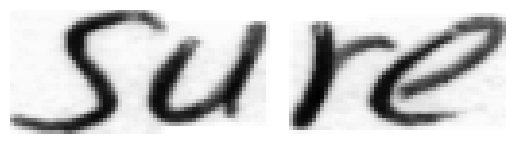

In [ ]:
# Regular resize
for img_path in train_img_paths:
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, 1)
    img = tf.image.resize(img, size=(32, 128))

    img_np = img.numpy().astype(np.uint8)

    if img_np.shape[-1] == 1:
        img_np = img_np.squeeze()

    plt.imshow(img_np, cmap="gray")
    plt.axis("off")
    plt.show()
    break

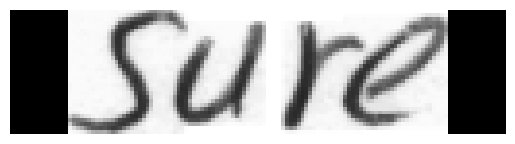

In [ ]:
# Distortion free resize
for img_path in train_img_paths:
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, 1)
    img = distortion_free_resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))

    img_np = img.numpy().astype(np.uint8)

    if img_np.shape[-1] == 1:
        img_np = img_np.squeeze()

    plt.imshow(img_np, cmap="gray")
    plt.axis("off")
    plt.show()
    break

Creating final datasets

In [ ]:
def preprocess_image(image_path: str, img_size: Tuple[int, int] = (IMAGE_HEIGHT, IMAGE_WIDTH)) -> TensorLike:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0 # normalize data

    return image

def vectorize_label(label: str, padding_token: int = PADDING_TOKEN) -> TensorLike:
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)

    return label

def augment_image(image):
    # losowa jasność
    image = tf.image.random_brightness(image, max_delta=0.2)
    # losowy kontrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # drobna losowa rotacja np. -5 do 5 stopni
    # Uwaga: tf.image.rot90 obraca o 90 stopni – nie o to chodzi
    # można użyć tf.keras.preprocessing.image.random_rotation,
    # ale w tf 2.x jest to trudniejsze do wpięcia w pipeline
    # Inny sposób – transformacje macierzowe z tf.keras.layers.experimental.preprocessing
    return image

def process_images_labels(image_path: str, label: str) -> Tuple[TensorLike, TensorLike]:
    image = preprocess_image(image_path)
    image = augment_image(image)
    label = vectorize_label(label)

    return image, label

def prepare_dataset(image_paths: list, labels: list, batch_size: int = BATCH_SIZE) -> tf.data.Dataset:
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )

    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [ ]:
train_ds = prepare_dataset(image_paths=train_img_paths, labels=train_labels_cleaned)
val_ds = prepare_dataset(image_paths=val_img_paths, labels=val_labels_cleaned)
test_ds = prepare_dataset(image_paths=test_img_paths, labels=test_labels_cleaned)

In [ ]:
for data in train_ds.take(1):
    print(data[0].shape)

(32, 32, 128, 1)


# Show example data

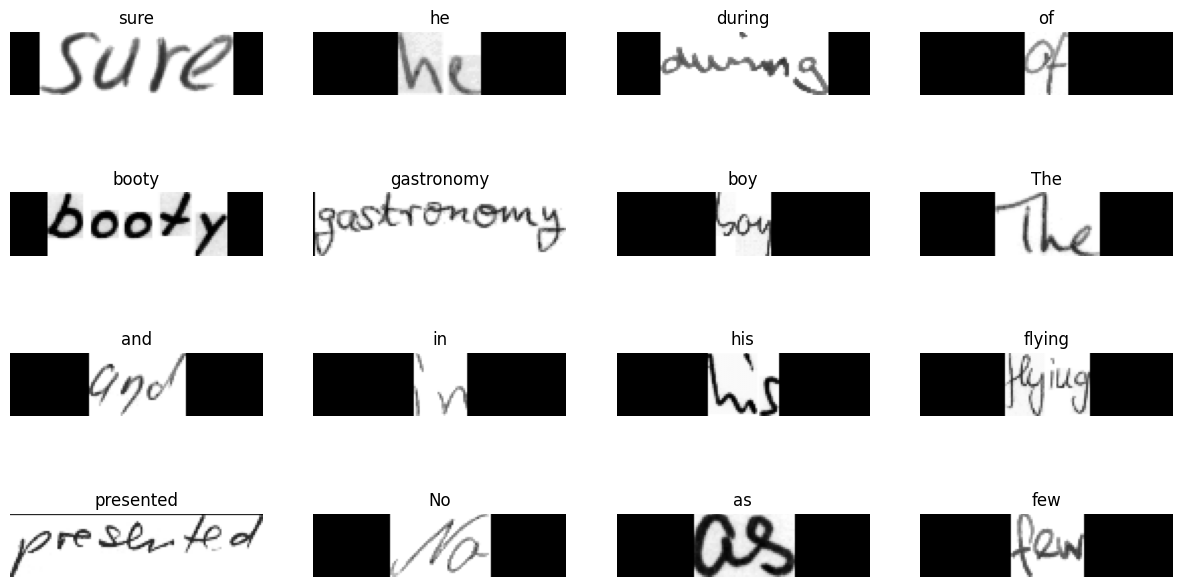

In [ ]:
for data in train_ds.take(1):
    # images, labels = data["image"], data["label"]
    images, labels = data

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        # img = tf.image.flip_left_right(img)
        # img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label != padding_token
        label = labels[i]

        indices = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))

        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Build model

In [ ]:
@register_keras_serializable(package="Custom")
def CTCLoss(y_true: TensorLike, y_pred: TensorLike, padding_token: int = PADDING_TOKEN) -> tf.Tensor:
    """
    y_true: (batch, max_len) with character indices and 99 as PAD (padding).
    y_pred: (batch, time_steps, vocab_size) - network output (logits or probabilities).
    """
    # Get batch size and number of time steps from shapes
    batch_size = tf.shape(y_true)[0]
    time_steps = tf.shape(y_pred)[1]

    # Calculate how many characters are not the padding token (actual sequence length per sample) - in other words count label len with no padding values
    label_length = tf.reduce_sum(
        tf.cast(tf.not_equal(y_true, padding_token), tf.int32),
        axis=1,       # sum along the character (sequence) axis
        keepdims=True # the result will then have shape (batch, 1)
    )

    # For the predictions y_pred, we assume each sample has input_length = time_steps
    input_length = time_steps * tf.ones((batch_size, 1), dtype=tf.int32)

    # ctc_batch_cost expects (y_true, y_pred, input_length, label_length)
    loss = keras.backend.ctc_batch_cost(
        y_true,       # true labels
        y_pred,       # predictions
        input_length, # number of time steps per sample
        label_length  # actual length of each label (no pads)
    )
    return loss


@register_keras_serializable(package="Custom")
def ctc_accuracy(y_true: TensorLike, y_pred: TensorLike, padding_token: int = PADDING_TOKEN) -> tf.Tensor:
    """
    y_true: (batch, max_len) with PAD=99
    y_pred: (batch, time_steps, vocab_size)
    """
    batch_size = tf.shape(y_pred)[0]
    time_steps = tf.shape(y_pred)[1]

    # The decoder requires the length of each input sequence
    # Here, we assume it's simply time_steps for all samples
    input_lengths = tf.fill([batch_size], time_steps)

    # Remove the padding from y_true and create a SparseTensor of actual labels
    y_true = tf.cast(y_true, tf.int64)
    indices = tf.where(tf.not_equal(y_true, padding_token))  # positions where value != 99
    values = tf.gather_nd(y_true, indices)                   # extract those values
    dense_shape = tf.cast(tf.shape(y_true), tf.int64)
    y_true_sparse = tf.SparseTensor(indices, values, dense_shape)

    # Greedy decoding of y_pred:
    # We transpose y_pred to shape (time_steps, batch, vocab_size),
    # because tf.nn.ctc_greedy_decoder expects it in this format.
    decoded, _ = tf.nn.ctc_greedy_decoder(
        tf.transpose(y_pred, [1, 0, 2]),
        input_lengths,
        merge_repeated=True
    )
    # Cast the decoded result to int64
    decoded_sparse = tf.cast(decoded[0], tf.int64)

    # Calculate accuracy via edit distance:
    # accuracy = 1 - average_edit_distance
    accuracy = 1 - tf.reduce_mean(
        tf.edit_distance(decoded_sparse, y_true_sparse, normalize=True)
    )
    return accuracy

#Model Summary

## 1. Input Layer:
Accepts grayscale images of a defined height and width.
<br>
<br>
## 2. Convolutional Blocks (CNN):

Block 1 & 2: Each block performs convolution with increasing filter counts (32 then 64), followed by batch normalization, ReLU activation, and max pooling. This reduces spatial dimensions while capturing basic and then more complex features.
Block 3: Applies additional convolution with 64 filters, batch normalization, and ReLU activation without pooling, refining the feature maps further.
<br>
<br>

## 3. Permutation and Reshaping:
The output tensor from the CNN layers is rearranged by swapping the height and width dimensions. It is then reshaped so that the height and filter dimensions are merged into a single feature dimension, creating a sequential representation for subsequent processing.
<br>
<br>


## 4. Recurrent Layers (RNN):
Multiple bidirectional GRU layers process the sequential data. They capture temporal dependencies in the extracted features, which is critical for sequence tasks like OCR.
<br>
<br>

## 5.Dense Layers and Output:
A fully connected dense layer with ReLU activation (and dropout for regularization) further processes the features. The final dense layer uses a softmax activation to produce character probability distributions. An extra output unit is included to handle the blank label required by the CTC loss.
<br>
<br>

## 6. Compilation:
The model is compiled with the Adam optimizer and a custom CTC loss function, making it well-suited for OCR tasks where alignment between predictions and actual sequences can vary.
<br>
<br>

In [ ]:
def build_model4(
    char_to_num: keras.layers.StringLookup,
    img_width: int = IMAGE_WIDTH,
    img_height: int = IMAGE_HEIGHT,
    rnn_layers: int = RNN_LAYERS,
    rnn_units: int = RNN_UNITS,
    learning_rate: float = LEARNING_RATE
) -> keras.Model:

    img_input = keras.Input(shape=(img_height, img_width, 1), name="image")

    # CNN 1
    x = keras.layers.Conv2D(32, (3, 3), padding="same", use_bias=False)(img_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)

    # CNN 2
    x = keras.layers.Conv2D(64, (3, 3), padding="same", use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)

    # CNN 3 (no pooling)
    x = keras.layers.Conv2D(64, (3, 3), padding="same", use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # Axis swap (height and width) => (batch, W//4, H//4, 64)
    x = keras.layers.Permute((2, 1, 3), name="permute")(x)

    # Reshape: (batch, W//4, (H//4)*64)
    x = keras.layers.Reshape(
        (img_width // 4, (img_height // 4) * 64),
        name="reshape"
    )(x)

    for i in range(rnn_layers):
        x = keras.layers.Bidirectional(
            keras.layers.GRU(rnn_units, return_sequences=True, recurrent_dropout=0.1)
        )(x)

    x = keras.layers.Dense(rnn_units * 2, activation="relu", name="dense_1")(x)
    x = keras.layers.Dropout(0.3)(x)

    vocab_size = len(char_to_num.get_vocabulary())
    output = keras.layers.Dense(
        vocab_size + 1,
        activation="softmax",
        name="dense_2"
    )(x)

    model = keras.Model(inputs=img_input, outputs=output)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=CTCLoss,
        metrics=[ctc_accuracy]
    )
    return model

In [ ]:
validation_images = []
validation_labels = []

for batch in val_ds:
    images, labels = batch
    for i in range(images.shape[0]):
        validation_images.append(images[i])   # (32, 128, 1)
        validation_labels.append(labels[i])

In [ ]:
def remove_padding_with_ragged(labels, pad_token: int = PADDING_TOKEN, no_sparse: bool = False):
    """
    Usuwa wszystkie wystąpienia `pad_token` z sekwencji za pomocą RaggedTensors.
    labels ma kształt (batch, max_len).
    Zwraca sparse tensor bez 99.
    """
    # Tworzymy RaggedTensor, który ignoruje pad_token:
    ragged = tf.ragged.boolean_mask(labels, labels != pad_token)
    # Konwertujemy RaggedTensor -> SparseTensor
    if no_sparse:
        return ragged
    return ragged.to_sparse()


def calculate_edit_distance(labels, predictions, max_len=None, pad_token=PADDING_TOKEN):
    """
    Zwraca średnią odległość edycyjną (edit distance) w batchu.
    labels: (batch, max_len) z wypełnieniem 99.
    predictions: (batch, time_steps, vocab_size) – wyniki modelu.
    """

    # 1) Zamiana etykiet na tensor rzadki, bez 99
    sparse_labels = remove_padding_with_ragged(labels, pad_token=pad_token)
    sparse_labels = tf.cast(sparse_labels, dtype=tf.int64)

    # 2) Dekodowanie predykcji przez CTC
    batch_size = predictions.shape[0]
    time_steps = predictions.shape[1]
    # ctc_decode oczekuje, że input_length będzie Tensorem
    input_len = tf.ones([batch_size], dtype=tf.int32) * time_steps

    decoded, _ = keras.backend.ctc_decode(
        predictions,
        input_length=input_len,
        greedy=True,
    )
    # decoded to lista wyników (tu jest tylko 1 element przy greedy=True)
    # kształt: (batch, max_decoded_length)
    predictions_decoded = decoded[0]

    # Jeśli chcesz skrócić do `max_len` (np. unikając zbyt długich wyjść):
    if max_len is not None:
        predictions_decoded = predictions_decoded[:, :max_len]

    # 3) Zamiana zdekodowanych predykcji na tensor rzadki
    #    (tu zwykle nie ma 99, więc wystarczy from_dense)
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    # 4) Obliczenie odległości edycyjnej (tu na przykład normalizowanej)
    edit_distances = tf.edit_distance(
        sparse_predictions,
        sparse_labels,
        normalize=True
    )

    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    """
    Callback obliczający średnią odległość edycyjną (mean edit distance)
    po każdej epoce na zbiorze walidacyjnym.
    """

    def __init__(self, pred_model, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.validation_images = validation_images
        self.validation_labels = validation_labels

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(self.validation_images)):
            # Obraz: zakładamy, że self.validation_images[i] to (128, 32, 1).
            # Dodanie wymiaru batch -> (1, 128, 32, 1).
            single_image = self.validation_images[i][None, ...]

            # Etykiety: jeśli self.validation_labels[i] ma kształt (seq_len,),
            # to dodanie wymiaru batch -> (1, seq_len).
            single_label = self.validation_labels[i][None, ...]

            # Predykcja
            predictions = self.prediction_model.predict(single_image, verbose=0)

            # Obliczanie edytowalności
            ed = calculate_edit_distance(single_label, predictions).numpy()
            edit_distances.append(ed)

        mean_ed = np.mean(edit_distances)
        print(f" Mean edit distance for epoch {epoch + 1}: {mean_ed:.4f}")


In [ ]:
def load_latest_checkpoint(checkpoint_dir: str = CHECKPOINT_DIR) -> bool:
    # Get all checkpoint files and sort them
    checkpoints = sorted([(f, int(f.split("_")[1].split(".")[0])) for f in os.listdir(CHECKPOINT_DIR) if f.startswith('checkpoint_')])

    if checkpoints:
        latest_checkpoint_el = max(checkpoints, key=lambda x: x[1])
        latest_checkpoint = os.path.join(checkpoint_dir, latest_checkpoint_el[0])
        print(f"Loading checkpoint: {latest_checkpoint}")
        model = tf.keras.models.load_model(latest_checkpoint)

        return True, model
    return False, None

In [ ]:
if not LOAD_CHECKPOINT:
    print("Loading fresh model")
    model = build_model4(char_to_num)
else:
    res, model = load_latest_checkpoint()

Loading checkpoint: /content/drive/MyDrive/ocr_checkpoints/checkpoint_48.keras


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 128, 32)         │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 128, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 64, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 32, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 32, 64)           │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 32, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 8, 32, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute (Permute)                    │ (None, 32, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 32, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32, 1024)            │       3,151,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 32, 1024)            │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 32, 1024)            │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32, 1024)            │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32, 80)              │          82,0

 Total params: 41,366,866 (157.80 MB)

 Trainable params: 13,788,848 (52.60 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 27,577,698 (105.20 MB)

In [ ]:
model.input

<KerasTensor shape=(None, 32, 128, 1), dtype=float32, sparse=False, name=image>

In [ ]:
prediction_model = keras.models.Model(
    model.input,
    model.get_layer(name="dense_2").output
)

In [ ]:
prediction_model.input

<KerasTensor shape=(None, 32, 128, 1), dtype=float32, sparse=False, name=image>

In [ ]:
assert prediction_model.input == model.input

**Training, logging, saving checkpoint**

In [ ]:
class CustomCSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_path):
        super().__init__()
        self.log_path = log_path
        self.epoch = 0

    def on_train_begin(self, logs = None) -> None:
        if os.path.exists(self.log_path):
            self.mode = "a"
            self.header = False
        else:
            self.mode = "w"
            self.header = True

        self.csvfile = open(self.log_path, self.mode, newline='')
        self.writer = csv.writer(self.csvfile)

        if self.header:
            self.writer.writerow(["epoch", "loss", "val_loss", "ctc_accuracy", "val_ctc_accuracy"])
            self.csvfile.flush()
        self.csvfile.close()

    def on_epoch_end(self, epoch: int, logs = None) -> None:
        logs = logs or {}
        with open(self.log_path, "a", newline='') as csvfile:
            writer = csv.writer(csvfile)
            row = [
                epoch,  # numer epoki
                logs.get("loss", "N/A"),
                logs.get("val_loss", "N/A"),
                logs.get("ctc_accuracy", "N/A"),
                logs.get("val_ctc_accuracy", "N/A"),
            ]
            writer.writerow(row)

In [ ]:
class PeriodicCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, base_checkpoint_callback, period=10):
        super().__init__()
        self.base_checkpoint_callback = base_checkpoint_callback
        self.period = period

    def on_train_begin(self, logs=None):
        self.base_checkpoint_callback.set_model(self.model)
        self.base_checkpoint_callback.set_params(self.params)

        self.base_checkpoint_callback.on_train_begin(logs)

    def on_train_batch_end(self, batch, logs=None):
        self.base_checkpoint_callback.on_train_batch_end(batch, logs)

    def on_epoch_begin(self, epoch, logs=None):
        self.base_checkpoint_callback.on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            self.base_checkpoint_callback.on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        self.base_checkpoint_callback.on_train_end(logs)

In [ ]:
reg_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH + ".keras",
        save_weights_only=False,
        save_best_only=True,
        monitor="val_ctc_accuracy", # ew zmienic na val_ctc_accuracy z val_loss
        verbose=1
    )

In [ ]:
checkpoint_every_period = PeriodicCheckpoint(reg_checkpoint, period=3)

In [ ]:
lr_reduction = keras.callbacks.ReduceLROnPlateau(
      monitor="val_loss",
      factor=0.5,
      patience=5,
      min_lr=1e-6
  )

In [ ]:
callbacks = [
     checkpoint_every_period,
     CustomCSVLogger(fr"{CHECKPOINT_DIR}/training_log.csv"),
     EditDistanceCallback(prediction_model, validation_images[:200], validation_labels[:200]),
     lr_reduction
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[callbacks],
    initial_epoch=55 # last epoch, counting from 0, so checkpoint id - 1 or -2 maybe

)

Epoch 56/65
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - ctc_accuracy: 0.9933 - loss: 0.0682 Mean edit distance for epoch 56: 11.4620
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 1350s 560ms/step - ctc_accuracy: 0.9933 - loss: 0.0682 - val_ctc_accuracy: 0.9023 - val_loss: 3.1919 - learning_rate: 5.0000e-05
Epoch 57/65
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - ctc_accuracy: 0.9952 - loss: 0.0450
Epoch 57: val_ctc_accuracy improved from 0.89830 to 0.90399, saving model to /content/drive/MyDrive/ocr_checkpoints/checkpoint_57.keras
 Mean edit distance for epoch 57: 11.4751
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 1386s 575ms/step - ctc_accuracy: 0.9952 - loss: 0.0450 - val_ctc_accuracy: 0.9040 - val_loss: 3.3415 - learning_rate: 5.0000e-05
Epoch 58/65
 201/2412 ━━━━━━━━━━━━━━━━━━━━ 19:13 522ms/step - ctc_accuracy: 0.9948 - loss: 0.0481

In [ ]:
train_hist_df = pd.read_csv(fr"{CHECKPOINT_DIR}/training_log.csv")
train_hist_df.columns

Index(['epoch', 'loss', 'val_loss', 'ctc_accuracy', 'val_ctc_accuracy'], dtype='object')

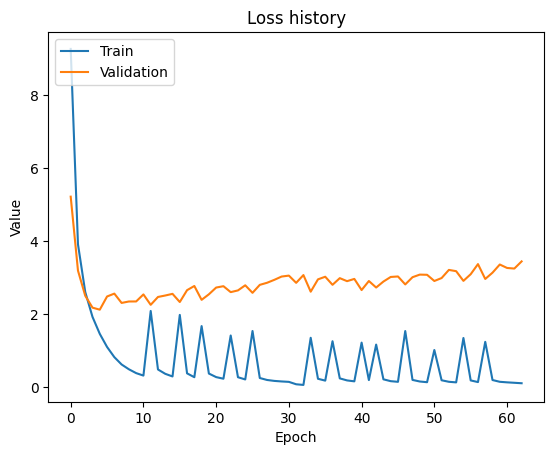

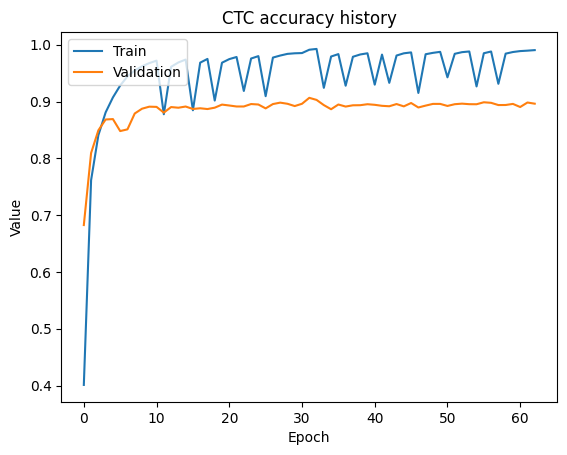

In [ ]:
plt.plot(train_hist_df["loss"])
plt.plot(train_hist_df["val_loss"])
plt.title("Loss history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_hist_df["ctc_accuracy"])
plt.plot(train_hist_df["val_ctc_accuracy"])
plt.title("CTC accuracy history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    # Iterate over the results and get back the text.
    output_text = []

    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)

    return output_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


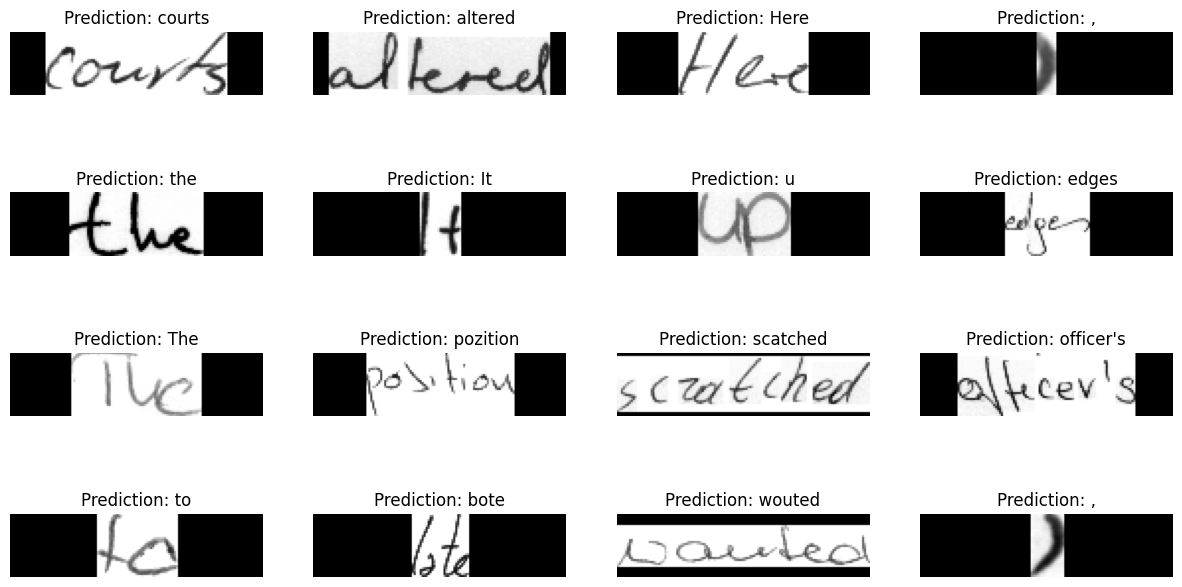

In [ ]:
# Let's check results on some test samples.
for  batch_images, bath_labels in test_ds.take(1):
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        # img = tf.image.flip_left_right(img)
        # img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

    plt.show()

# Save model

In [ ]:
prediction_model.save(MODEL_PATH)

with open(NUM2CHAR_PATH, "wb") as c2n_file:
    pickle.dump(num_to_char, c2n_file)

# Load model

In [ ]:
loaded_prediction_model = keras.models.load_model(MODEL_PATH)
loaded_prediction_model.compile()
# loaded_prediction_model.evaluate()
with open(NUM2CHAR_PATH, "rb") as n2c_f:
    num_to_char = pickle.load(n2c_f)

# Test on whole test dataset

In [ ]:
def levenshtein_distance(s1, s2):
    """Zwraca dystans Levenshteina między dwoma łańcuchami znaków."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    # s1 ma co najmniej tyle znaków co s2
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

In [ ]:
"""
Interpretacja:

CER = 0.0 oznacza, że wszystkie znaki we wszystkich przykładach zostały przewidziane idealnie.
CER = 0.05 (5%) oznacza, że średnio na 100 znaków mamy 5 „poprawek” (wstawienie, usunięcie lub podmiana).
"""

total_distance = 0
total_chars = 0

for batch_img, batch_labels in tqdm(test_ds):
    preds = prediction_model.predict(batch_img)
    pred_texts = decode_batch_predictions(preds)

    for pred_text, label in zip(pred_texts, batch_labels.numpy()):
        # print(label)
        cleaned_label = remove_padding_with_ragged(label, no_sparse=True)
        label_text = tf.gather(cleaned_label, tf.where(tf.math.not_equal(cleaned_label, -1)))
        label_text = tf.strings.reduce_join(num_to_char(label_text)).numpy().decode("utf-8")
          # output_text.append(res)
        # res = tf.gather(label, tf.where(tf.math.not_equal(label, -1)))
        # res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        # output_text.append(res)

        # print(label_text)
        dist = levenshtein_distance(pred_text, label_text)
        total_distance += dist
        total_chars += len(label_text)

cer = total_distance / total_chars
print()
print("CER =", cer) # CER = 0.117485245573672

  0%|          | 0/151 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  1%|          | 1/151 [00:00<01:12,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  1%|▏         | 2/151 [00:00<01:03,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  2%|▏         | 3/151 [00:01<01:01,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  3%|▎         | 4/151 [00:01<01:00,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|▎         | 5/151 [00:02<01:00,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  4%|▍         | 6/151 [00:02<00:59,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  5%|▍         | 7/151 [00:02<00:57,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|▌         | 8/151 [00:03<00:56,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  6%|▌         | 9/151 [00:03<00:55,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|▋         | 10/151 [00:04<00:55,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  7%|▋         | 11/151 [00:04<00:54,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  8%|▊         | 12/151 [00:04<00:54,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  9%|▊         | 13/151 [00:05<00:54,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|▉         | 14/151 [00:05<00:53,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 10%|▉         | 15/151 [00:05<00:53,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 11%|█         | 16/151 [00:06<00:53,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 11%|█▏        | 17/151 [00:06<00:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 12%|█▏        | 18/151 [00:07<00:55,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 13%|█▎        | 19/151 [00:07<01:03,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 13%|█▎        | 20/151 [00:08<01:07,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 14%|█▍        | 21/151 [00:09<01:13,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 15%|█▍        | 22/151 [00:09<01:15,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 15%|█▌        | 23/151 [00:10<01:06,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 16%|█▌        | 24/151 [00:10<01:01,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 17%|█▋        | 25/151 [00:10<00:56,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 17%|█▋        | 26/151 [00:11<00:54,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 18%|█▊        | 27/151 [00:11<00:51,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 19%|█▊        | 28/151 [00:12<00:49,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 19%|█▉        | 29/151 [00:12<00:49,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|█▉        | 30/151 [00:12<00:47,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 21%|██        | 31/151 [00:13<00:47,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|██        | 32/151 [00:13<00:47,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 22%|██▏       | 33/151 [00:14<00:46,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 23%|██▎       | 34/151 [00:14<00:46,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 23%|██▎       | 35/151 [00:14<00:46,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 24%|██▍       | 36/151 [00:15<00:45,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 25%|██▍       | 37/151 [00:15<00:44,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 25%|██▌       | 38/151 [00:16<00:44,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 26%|██▌       | 39/151 [00:16<00:43,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 26%|██▋       | 40/151 [00:16<00:42,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|██▋       | 41/151 [00:17<00:42,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 28%|██▊       | 42/151 [00:17<00:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 28%|██▊       | 43/151 [00:17<00:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 29%|██▉       | 44/151 [00:18<00:41,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 30%|██▉       | 45/151 [00:18<00:42,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 30%|███       | 46/151 [00:19<00:42,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 31%|███       | 47/151 [00:19<00:42,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 32%|███▏      | 48/151 [00:20<00:43,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 32%|███▏      | 49/151 [00:20<00:50,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 33%|███▎      | 50/151 [00:21<00:53,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 34%|███▍      | 51/151 [00:21<00:57,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 34%|███▍      | 52/151 [00:22<00:57,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 35%|███▌      | 53/151 [00:22<00:52,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 36%|███▌      | 54/151 [00:23<00:47,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 36%|███▋      | 55/151 [00:23<00:44,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 37%|███▋      | 56/151 [00:24<00:42,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 38%|███▊      | 57/151 [00:24<00:40,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 38%|███▊      | 58/151 [00:25<00:39,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 39%|███▉      | 59/151 [00:25<00:38,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 40%|███▉      | 60/151 [00:25<00:37,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 40%|████      | 61/151 [00:26<00:37,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 41%|████      | 62/151 [00:26<00:36,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 42%|████▏     | 63/151 [00:27<00:35,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 42%|████▏     | 64/151 [00:27<00:34,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 43%|████▎     | 65/151 [00:27<00:35,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 44%|████▎     | 66/151 [00:28<00:34,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 44%|████▍     | 67/151 [00:28<00:34,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 45%|████▌     | 68/151 [00:29<00:33,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 46%|████▌     | 69/151 [00:29<00:32,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████▋     | 70/151 [00:29<00:32,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████▋     | 71/151 [00:30<00:31,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 48%|████▊     | 72/151 [00:30<00:31,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 48%|████▊     | 73/151 [00:31<00:31,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 49%|████▉     | 74/151 [00:31<00:30,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 50%|████▉     | 75/151 [00:31<00:29,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|█████     | 76/151 [00:32<00:29,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 51%|█████     | 77/151 [00:32<00:30,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 52%|█████▏    | 78/151 [00:33<00:34,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 52%|█████▏    | 79/151 [00:33<00:38,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 53%|█████▎    | 80/151 [00:34<00:40,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 54%|█████▎    | 81/151 [00:35<00:40,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 54%|█████▍    | 82/151 [00:35<00:36,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 55%|█████▍    | 83/151 [00:36<00:33,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 56%|█████▌    | 84/151 [00:36<00:31,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 56%|█████▋    | 85/151 [00:36<00:29,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 57%|█████▋    | 86/151 [00:37<00:28,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 58%|█████▊    | 87/151 [00:37<00:26,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 58%|█████▊    | 88/151 [00:38<00:25,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 59%|█████▉    | 89/151 [00:38<00:24,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 60%|█████▉    | 90/151 [00:38<00:24,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 60%|██████    | 91/151 [00:39<00:23,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 61%|██████    | 92/151 [00:39<00:23,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 62%|██████▏   | 93/151 [00:39<00:23,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 62%|██████▏   | 94/151 [00:40<00:22,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 63%|██████▎   | 95/151 [00:40<00:21,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 64%|██████▎   | 96/151 [00:41<00:21,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 64%|██████▍   | 97/151 [00:41<00:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 65%|██████▍   | 98/151 [00:41<00:20,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 66%|██████▌   | 99/151 [00:42<00:20,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 66%|██████▌   | 100/151 [00:42<00:20,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 67%|██████▋   | 101/151 [00:43<00:19,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 68%|██████▊   | 102/151 [00:43<00:19,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 68%|██████▊   | 103/151 [00:43<00:19,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 69%|██████▉   | 104/151 [00:44<00:18,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 70%|██████▉   | 105/151 [00:44<00:18,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 70%|███████   | 106/151 [00:45<00:17,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 71%|███████   | 107/151 [00:45<00:20,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 108/151 [00:46<00:21,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 72%|███████▏  | 109/151 [00:46<00:22,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 73%|███████▎  | 110/151 [00:47<00:23,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 74%|███████▎  | 111/151 [00:48<00:22,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 74%|███████▍  | 112/151 [00:48<00:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 75%|███████▍  | 113/151 [00:48<00:18,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 75%|███████▌  | 114/151 [00:49<00:16,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 76%|███████▌  | 115/151 [00:49<00:15,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 77%|███████▋  | 116/151 [00:50<00:14,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 77%|███████▋  | 117/151 [00:50<00:14,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 78%|███████▊  | 118/151 [00:50<00:13,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 79%|███████▉  | 119/151 [00:51<00:13,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 79%|███████▉  | 120/151 [00:51<00:12,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 80%|████████  | 121/151 [00:52<00:12,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 81%|████████  | 122/151 [00:52<00:11,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 81%|████████▏ | 123/151 [00:52<00:11,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 82%|████████▏ | 124/151 [00:53<00:10,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 83%|████████▎ | 125/151 [00:53<00:10,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 83%|████████▎ | 126/151 [00:54<00:09,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 84%|████████▍ | 127/151 [00:54<00:09,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 85%|████████▍ | 128/151 [00:54<00:09,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 85%|████████▌ | 129/151 [00:55<00:08,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 86%|████████▌ | 130/151 [00:55<00:08,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 87%|████████▋ | 131/151 [00:56<00:07,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 87%|████████▋ | 132/151 [00:56<00:07,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 88%|████████▊ | 133/151 [00:56<00:07,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 89%|████████▊ | 134/151 [00:57<00:06,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 89%|████████▉ | 135/151 [00:57<00:06,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 90%|█████████ | 136/151 [00:58<00:06,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 91%|█████████ | 137/151 [00:58<00:06,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 91%|█████████▏| 138/151 [00:59<00:06,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 139/151 [00:59<00:05,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 93%|█████████▎| 140/151 [01:00<00:05,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 93%|█████████▎| 141/151 [01:00<00:05,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 94%|█████████▍| 142/151 [01:01<00:04,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 95%|█████████▍| 143/151 [01:01<00:03,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|█████████▌| 144/151 [01:02<00:03,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 96%|█████████▌| 145/151 [01:02<00:02,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 97%|█████████▋| 146/151 [01:02<00:02,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 97%|█████████▋| 147/151 [01:03<00:01,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 98%|█████████▊| 148/151 [01:03<00:01,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 99%|█████████▊| 149/151 [01:04<00:00,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 99%|█████████▉| 150/151 [01:04<00:00,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


100%|██████████| 151/151 [01:21<00:00,  1.84it/s]

CER = 0.11723517055116535


In [ ]:
max_distance = 2  # np. pozwalamy na max. 2-literowy błąd
correct = 0
total = 0
correct_strict = 0

for batch_img, batch_labels in tqdm(test_ds):
    preds = prediction_model.predict(batch_img)
    pred_texts = decode_batch_predictions(preds)

    for pred_text, label in zip(pred_texts, batch_labels.numpy()):
        cleaned_label = remove_padding_with_ragged(label, no_sparse=True)
        label_text = tf.gather(cleaned_label, tf.where(tf.math.not_equal(cleaned_label, -1)))
        label_text = tf.strings.reduce_join(num_to_char(label_text)).numpy().decode("utf-8")
        dist = levenshtein_distance(pred_text, label_text)

        if dist <= max_distance:
            correct += 1
        if pred_text == label_text:
            correct_strict += 1
        total += 1

print()
accuracy_margin = correct / total
print(f"Accuracy w margin {max_distance} =", accuracy_margin)

accuracy_strict = correct_strict / total
print(f"Accuracy =", accuracy_strict)

  0%|          | 0/151 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


  1%|          | 1/151 [00:01<03:42,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


  1%|▏         | 2/151 [00:02<02:42,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  2%|▏         | 3/151 [00:03<02:24,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  3%|▎         | 4/151 [00:03<02:13,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


  3%|▎         | 5/151 [00:04<02:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


  4%|▍         | 6/151 [00:05<02:08,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


  5%|▍         | 7/151 [00:06<01:57,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


  5%|▌         | 8/151 [00:07<01:51,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


  6%|▌         | 9/151 [00:07<01:53,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  7%|▋         | 10/151 [00:08<01:54,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  7%|▋         | 11/151 [00:09<01:43,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  8%|▊         | 12/151 [00:10<01:45,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


  9%|▊         | 13/151 [00:11<02:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  9%|▉         | 14/151 [00:12<02:30,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 10%|▉         | 15/151 [00:14<02:36,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 11%|█         | 16/151 [00:14<02:16,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 11%|█▏        | 17/151 [00:15<02:01,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 12%|█▏        | 18/151 [00:16<02:06,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 13%|█▎        | 19/151 [00:17<01:56,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 13%|█▎        | 20/151 [00:18<01:56,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 14%|█▍        | 21/151 [00:18<01:37,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|█▍        | 22/151 [00:19<01:23,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 15%|█▌        | 23/151 [00:19<01:12,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 16%|█▌        | 24/151 [00:19<01:05,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 17%|█▋        | 25/151 [00:20<01:00,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 17%|█▋        | 26/151 [00:20<00:57,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 18%|█▊        | 27/151 [00:20<00:53,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 19%|█▊        | 28/151 [00:21<00:50,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 19%|█▉        | 29/151 [00:21<00:49,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 20%|█▉        | 30/151 [00:22<00:47,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|██        | 31/151 [00:22<00:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 21%|██        | 32/151 [00:22<00:46,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|██▏       | 33/151 [00:23<00:46,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 23%|██▎       | 34/151 [00:23<00:46,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 23%|██▎       | 35/151 [00:24<00:45,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 24%|██▍       | 36/151 [00:24<00:48,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|██▍       | 37/151 [00:25<00:49,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▌       | 38/151 [00:25<00:55,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 39/151 [00:26<00:53,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 26%|██▋       | 40/151 [00:26<00:58,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 27%|██▋       | 41/151 [00:27<00:56,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 28%|██▊       | 42/151 [00:27<00:51,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 28%|██▊       | 43/151 [00:27<00:48,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 29%|██▉       | 44/151 [00:28<00:45,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 30%|██▉       | 45/151 [00:28<00:43,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|███       | 46/151 [00:29<00:41,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 31%|███       | 47/151 [00:29<00:40,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 32%|███▏      | 48/151 [00:29<00:39,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 32%|███▏      | 49/151 [00:30<00:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|███▎      | 50/151 [00:30<00:37,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 34%|███▍      | 51/151 [00:30<00:37,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 34%|███▍      | 52/151 [00:31<00:37,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 35%|███▌      | 53/151 [00:31<00:37,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 36%|███▌      | 54/151 [00:32<00:36,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 36%|███▋      | 55/151 [00:32<00:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 37%|███▋      | 56/151 [00:32<00:35,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 38%|███▊      | 57/151 [00:33<00:36,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 38%|███▊      | 58/151 [00:33<00:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 39%|███▉      | 59/151 [00:34<00:35,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 40%|███▉      | 60/151 [00:34<00:34,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 40%|████      | 61/151 [00:34<00:34,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 41%|████      | 62/151 [00:35<00:33,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 42%|████▏     | 63/151 [00:35<00:33,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 42%|████▏     | 64/151 [00:35<00:33,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|████▎     | 65/151 [00:36<00:33,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 44%|████▎     | 66/151 [00:36<00:32,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 44%|████▍     | 67/151 [00:37<00:32,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 45%|████▌     | 68/151 [00:37<00:37,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 46%|████▌     | 69/151 [00:38<00:37,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 46%|████▋     | 70/151 [00:38<00:37,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 47%|████▋     | 71/151 [00:39<00:36,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 48%|████▊     | 72/151 [00:39<00:40,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 48%|████▊     | 73/151 [00:40<00:38,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 49%|████▉     | 74/151 [00:40<00:35,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 50%|████▉     | 75/151 [00:40<00:33,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 50%|█████     | 76/151 [00:41<00:31,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 51%|█████     | 77/151 [00:41<00:30,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 52%|█████▏    | 78/151 [00:42<00:29,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 52%|█████▏    | 79/151 [00:42<00:28,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 53%|█████▎    | 80/151 [00:42<00:28,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 54%|█████▎    | 81/151 [00:43<00:27,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 54%|█████▍    | 82/151 [00:43<00:26,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 55%|█████▍    | 83/151 [00:44<00:25,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 56%|█████▌    | 84/151 [00:44<00:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 56%|█████▋    | 85/151 [00:44<00:25,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 57%|█████▋    | 86/151 [00:45<00:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 58%|█████▊    | 87/151 [00:45<00:24,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 58%|█████▊    | 88/151 [00:45<00:24,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 59%|█████▉    | 89/151 [00:46<00:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 60%|█████▉    | 90/151 [00:46<00:23,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 60%|██████    | 91/151 [00:47<00:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 61%|██████    | 92/151 [00:47<00:22,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 62%|██████▏   | 93/151 [00:47<00:22,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 62%|██████▏   | 94/151 [00:48<00:22,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 63%|██████▎   | 95/151 [00:48<00:22,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 64%|██████▎   | 96/151 [00:49<00:21,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 64%|██████▍   | 97/151 [00:49<00:20,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 65%|██████▍   | 98/151 [00:49<00:20,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 66%|██████▌   | 99/151 [00:50<00:20,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 66%|██████▌   | 100/151 [00:50<00:23,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 67%|██████▋   | 101/151 [00:51<00:25,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 68%|██████▊   | 102/151 [00:51<00:24,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 68%|██████▊   | 103/151 [00:52<00:24,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 69%|██████▉   | 104/151 [00:53<00:24,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 70%|██████▉   | 105/151 [00:53<00:22,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 70%|███████   | 106/151 [00:53<00:20,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 71%|███████   | 107/151 [00:54<00:18,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 72%|███████▏  | 108/151 [00:54<00:17,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 72%|███████▏  | 109/151 [00:54<00:16,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 73%|███████▎  | 110/151 [00:55<00:16,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 74%|███████▎  | 111/151 [00:55<00:15,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 74%|███████▍  | 112/151 [00:56<00:15,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 75%|███████▍  | 113/151 [00:56<00:15,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 75%|███████▌  | 114/151 [00:56<00:14,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 76%|███████▌  | 115/151 [00:57<00:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 77%|███████▋  | 116/151 [00:57<00:13,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 77%|███████▋  | 117/151 [00:58<00:13,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 78%|███████▊  | 118/151 [00:58<00:12,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 79%|███████▉  | 119/151 [00:58<00:12,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 79%|███████▉  | 120/151 [00:59<00:12,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 80%|████████  | 121/151 [00:59<00:11,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 81%|████████  | 122/151 [00:59<00:11,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 81%|████████▏ | 123/151 [01:00<00:10,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 82%|████████▏ | 124/151 [01:00<00:10,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 83%|████████▎ | 125/151 [01:01<00:09,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 83%|████████▎ | 126/151 [01:01<00:09,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 84%|████████▍ | 127/151 [01:01<00:09,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 85%|████████▍ | 128/151 [01:02<00:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 85%|████████▌ | 129/151 [01:02<00:08,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 86%|████████▌ | 130/151 [01:03<00:09,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 87%|████████▋ | 131/151 [01:03<00:09,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 87%|████████▋ | 132/151 [01:04<00:10,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 88%|████████▊ | 133/151 [01:05<00:10,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 89%|████████▊ | 134/151 [01:05<00:09,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 89%|████████▉ | 135/151 [01:06<00:07,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 90%|█████████ | 136/151 [01:06<00:06,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 91%|█████████ | 137/151 [01:06<00:06,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 91%|█████████▏| 138/151 [01:07<00:05,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 92%|█████████▏| 139/151 [01:07<00:04,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 93%|█████████▎| 140/151 [01:07<00:04,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 93%|█████████▎| 141/151 [01:08<00:03,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 94%|█████████▍| 142/151 [01:08<00:03,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 95%|█████████▍| 143/151 [01:09<00:03,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|█████████▌| 144/151 [01:09<00:02,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 96%|█████████▌| 145/151 [01:09<00:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 97%|█████████▋| 146/151 [01:10<00:01,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 97%|█████████▋| 147/151 [01:10<00:01,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 98%|█████████▊| 148/151 [01:11<00:01,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 99%|█████████▊| 149/151 [01:11<00:00,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 99%|█████████▉| 150/151 [01:11<00:00,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


100%|██████████| 151/151 [01:21<00:00,  1.84it/s]

Accuracy z marginesem 2 = 0.9514724180837827
Accuracy dokladne  = 0.7260472832849441
